In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

import warnings
warnings.filterwarnings("ignore")

# 数据探查
df = pd.read_csv("./datasets/2022-2025软件、资讯类采购预算及执行情况_analysis.csv")
df.info()
# 将'已执行金额'列转换为数值类型（如果不是数值类型的话）
df['已执行金额'] = pd.to_numeric(df['已执行金额'], errors='coerce')
# 按照年份累加'已执行金额'
result = df.groupby('年份')['已执行金额'].sum()
# print(result)

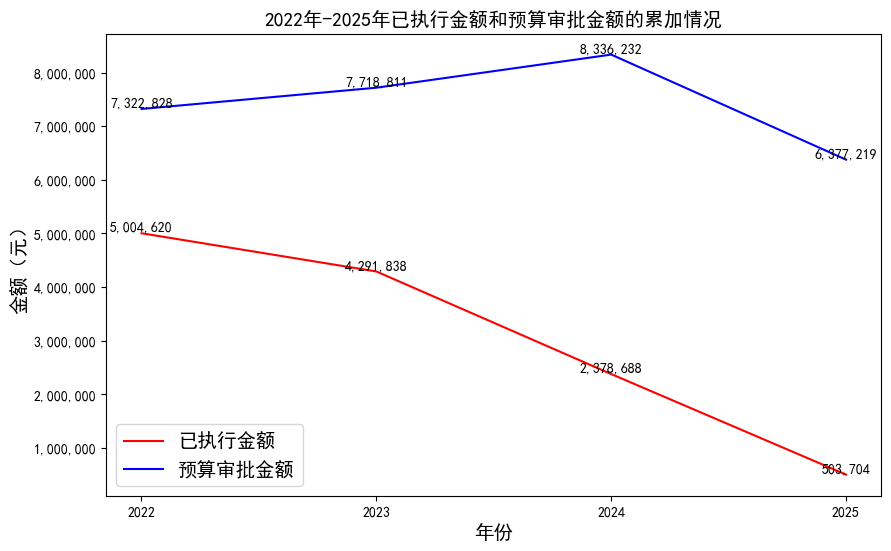

In [172]:
# 1-按采购时间的采购金额趋势
from matplotlib.font_manager import FontProperties # 设置中文字体，这里使用系统自带的黑体，你也可以根据实际情况选择其他合适的字体
font = FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf', size=14)

# 假设数据存储在名为data.csv的文件中，读取数据
data = pd.read_csv("./datasets/2022-2025软件、资讯类采购预算及执行情况_analysis.csv")


# 将'已执行金额'和'审批金额不含税'列转换为数值类型（如果不是数值类型的话）
data['已执行金额'] = pd.to_numeric(data['已执行金额'], errors='coerce')
data['审批金额不含税'] = pd.to_numeric(data['审批金额不含税'], errors='coerce')

# 确保年份为整数类型
data['年份'] = data['年份'].astype(int)

# 按照年份累加'已执行金额'和'审批金额不含税'
result = data.groupby('年份')[['已执行金额', '审批金额不含税']].sum()

# 绘制折线图 
fig, ax = plt.subplots(figsize=(10, 6))
result.plot(kind='line', ax=ax, color=['r', 'b'])
ax.set_xlabel('年份', fontproperties=font)
ax.set_ylabel('金额（元）', fontproperties=font)
ax.set_title('2022年-2025年已执行金额和预算审批金额的累加情况', fontproperties=font)
ax.legend(['已执行金额', '预算审批金额'], prop=font)

# 设置y轴刻度格式为金额展示
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

# 显示各个年份的统计数值
for i in result.index:
    for col in result.columns:
        value = result.loc[i, col]
        ax.text(i, value, f'{value:,.0f}', ha='center', va='bottom')

# 设置x轴刻度为整数
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

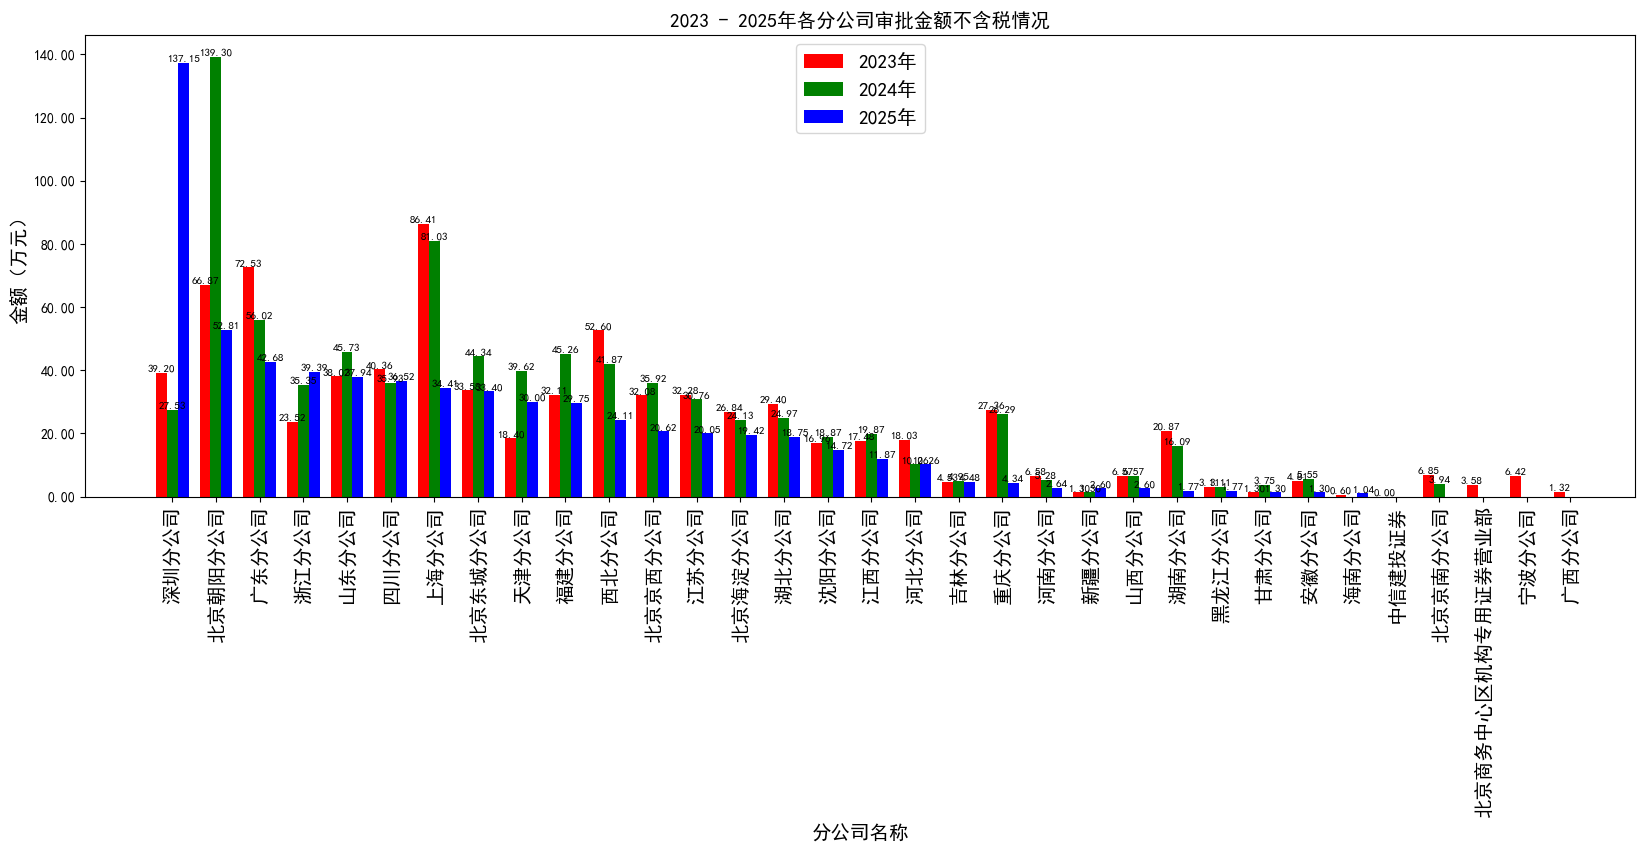

In [96]:
# 2-各分公司采购预算分布
# 设置字体
# 设置中文字体
font = FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf', size=14)

# 读取数据
data = pd.read_csv("./datasets/2022-2025软件、资讯类采购预算及执行情况_analysis.csv")

# 将'审批金额不含税'列转换为数值类型，缺失值填充为0
data['审批金额不含税'] = pd.to_numeric(data['审批金额不含税'], errors='coerce').fillna(0)

# 筛选出2023、2024、2025年的数据
data_selected_years = data[data['年份'].isin([2023, 2024, 2025])]

# 按照分公司名称和年份累加'审批金额不含税'，并转换单位为万元
result = data_selected_years.groupby(['分公司名称', '年份'])['审批金额不含税'].sum().reset_index()
result['审批金额不含税'] = result['审批金额不含税'] / 10000

# 重塑数据，使每个分公司对应不同年份的审批金额不含税为列
result_pivot = result.pivot(index='分公司名称', columns='年份', values='审批金额不含税').reset_index()

# 按2025年审批金额不含税降序排序（如果2025年有数据的话）
if 2025 in result_pivot.columns:
    result_pivot = result_pivot.sort_values(by = 2025, ascending = False)

# 绘制柱状图
bar_width = 0.25
index = range(len(result_pivot))
fig, ax = plt.subplots(figsize=(20, 6))

colors = ['r', 'g', 'b']
for i, year in enumerate([2023, 2024, 2025]):
    if year in result_pivot.columns:
        bars = ax.bar([j + i * bar_width for j in index], result_pivot[year], width = bar_width,
                      label = f'{year}年', color = colors[i])
        for bar in bars:
            height = bar.get_height()
            # 调整统计值字体大小
            ax.annotate(f'{height:.2f}',
                        (bar.get_x() + bar.get_width() / 2, height),
                        ha = 'center', va = 'bottom', fontsize = 8)

ax.set_xlabel('分公司名称', fontproperties = font)
ax.set_ylabel('金额（万元）', fontproperties = font)
ax.set_title('2023 - 2025年各分公司审批预算金额不含税情况', fontproperties = font)
ax.set_xticks([j + bar_width for j in index])
ax.set_xticklabels(result_pivot['分公司名称'], fontproperties = font, rotation = 90)
ax.legend(prop = font)

# 设置y轴刻度格式为金额展示，单位为万元
def format_y_axis(x, pos):
    return f'{x:.2f}'


formatter = ticker.FuncFormatter(format_y_axis)
ax.yaxis.set_major_formatter(formatter)

plt.show()

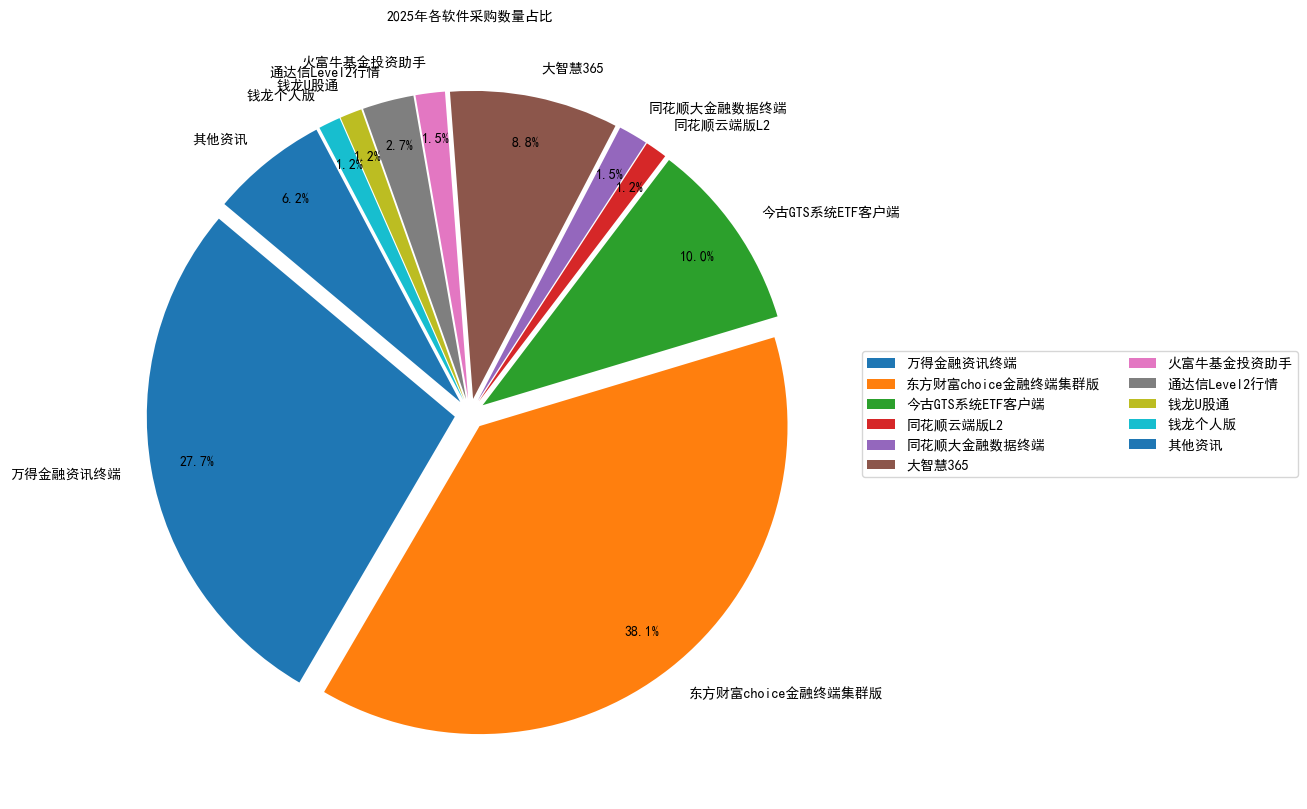

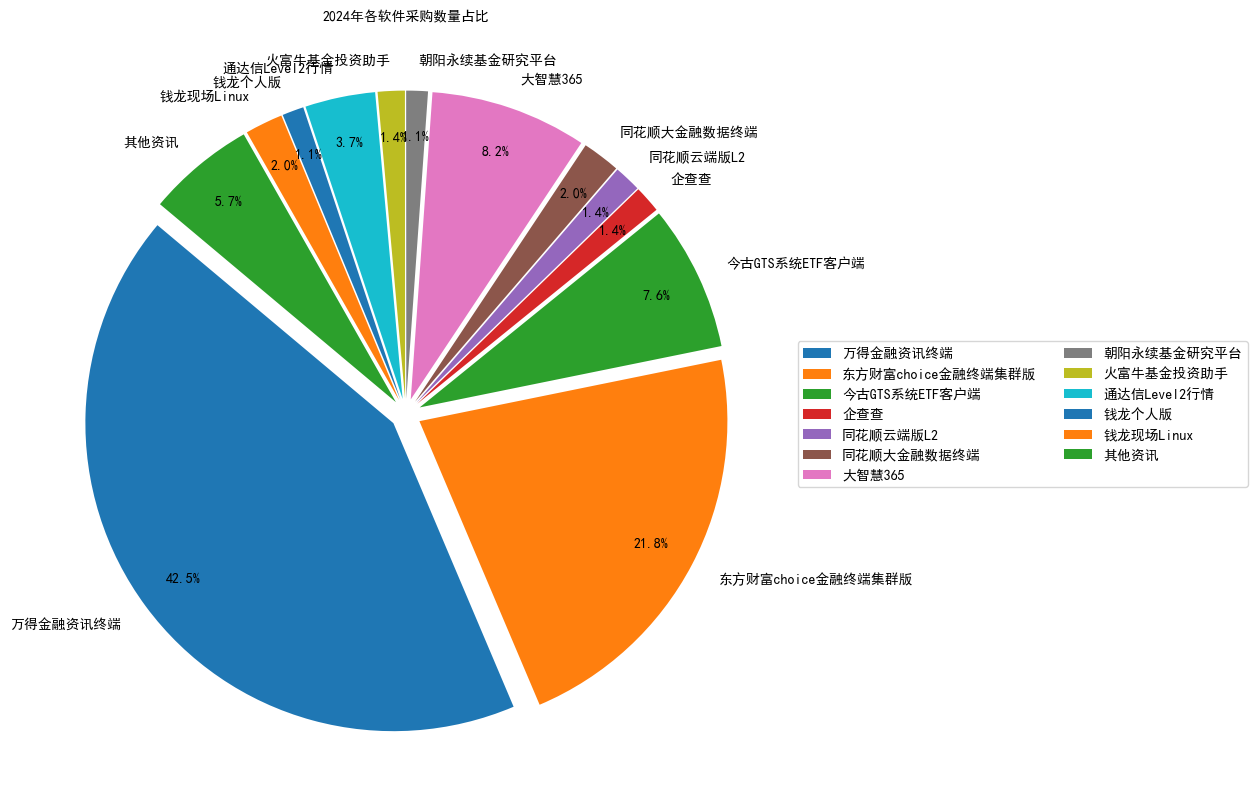

In [145]:
# 3-不同软件的采购占比-2025
font = FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf', size=10)

# 读取数据
data = pd.read_csv("./datasets/2022-2025软件、资讯类采购预算及执行情况_analysis.csv")

# 筛选出2025年的数据
data_2025 = data[data['年份'] == 2025]

# 按照软件名称统计数量
software_count = data_2025.groupby('软件名称').size().reset_index(name='数量')

# 计算总数量
total_count = software_count['数量'].sum()
# 筛选出占比小于1%的软件
others_mask = software_count['数量'] / total_count < 0.01
others_count = software_count[others_mask]['数量'].sum()
# 构建新的数据，将占比小于1%的合并为“其他资讯”
new_software_count = software_count[~others_mask]
others_df = pd.DataFrame({'软件名称': ['其他资讯'], '数量': [others_count]})
new_software_count = pd.concat([new_software_count, others_df], ignore_index=True)

# 绘制饼状图
explode = tuple([0.05] * len(new_software_count))
plt.figure(figsize=(10, 10))
patches, texts, autotexts = plt.pie(new_software_count['数量'], explode=explode, labels=new_software_count['软件名称'],
                                    autopct='%1.1f%%', startangle=140, pctdistance=0.85)

# 设置饼图中文标签字体
for text in texts:
    text.set_fontproperties(font)
for autotext in autotexts:
    autotext.set_fontproperties(font)

# 添加图例，调整位置避免遮挡饼图，调整字体大小和列数
plt.legend(patches, new_software_count['软件名称'], loc='center left', bbox_to_anchor=(1, 0.5),
           prop=font, ncol=2)

plt.title('2025年各软件采购数量占比', fontproperties=font)
plt.show()

# 3-不同软件分类的采购占比
font = FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf', size=10)

# #######################################################################################################################################
# 读取数据
data = pd.read_csv("./datasets/2022-2025软件、资讯类采购预算及执行情况_analysis.csv")

# 筛选出2024年的数据
data_2024 = data[data['年份'] == 2024]

# 按照软件名称统计数量
software_count = data_2024.groupby('软件名称').size().reset_index(name='数量')

# 计算总数量
total_count = software_count['数量'].sum()
# 筛选出占比小于1%的软件
others_mask = software_count['数量'] / total_count < 0.01
others_count = software_count[others_mask]['数量'].sum()
# 构建新的数据，将占比小于1%的合并为“其他资讯”
new_software_count = software_count[~others_mask]
others_df = pd.DataFrame({'软件名称': ['其他资讯'], '数量': [others_count]})
new_software_count = pd.concat([new_software_count, others_df], ignore_index=True)

# 绘制饼状图
explode = tuple([0.05] * len(new_software_count))
plt.figure(figsize=(10, 10))
patches, texts, autotexts = plt.pie(new_software_count['数量'], explode=explode, labels=new_software_count['软件名称'],
                                    autopct='%1.1f%%', startangle=140, pctdistance=0.85)

# 设置饼图中文标签字体
for text in texts:
    text.set_fontproperties(font)
for autotext in autotexts:
    autotext.set_fontproperties(font)

# 添加图例，调整位置避免遮挡饼图，调整字体大小和列数
plt.legend(patches, new_software_count['软件名称'], loc='center left', bbox_to_anchor=(1, 0.5),
           prop=font, ncol=2)

plt.title('2024年各软件采购数量占比', fontproperties=font)
plt.show()


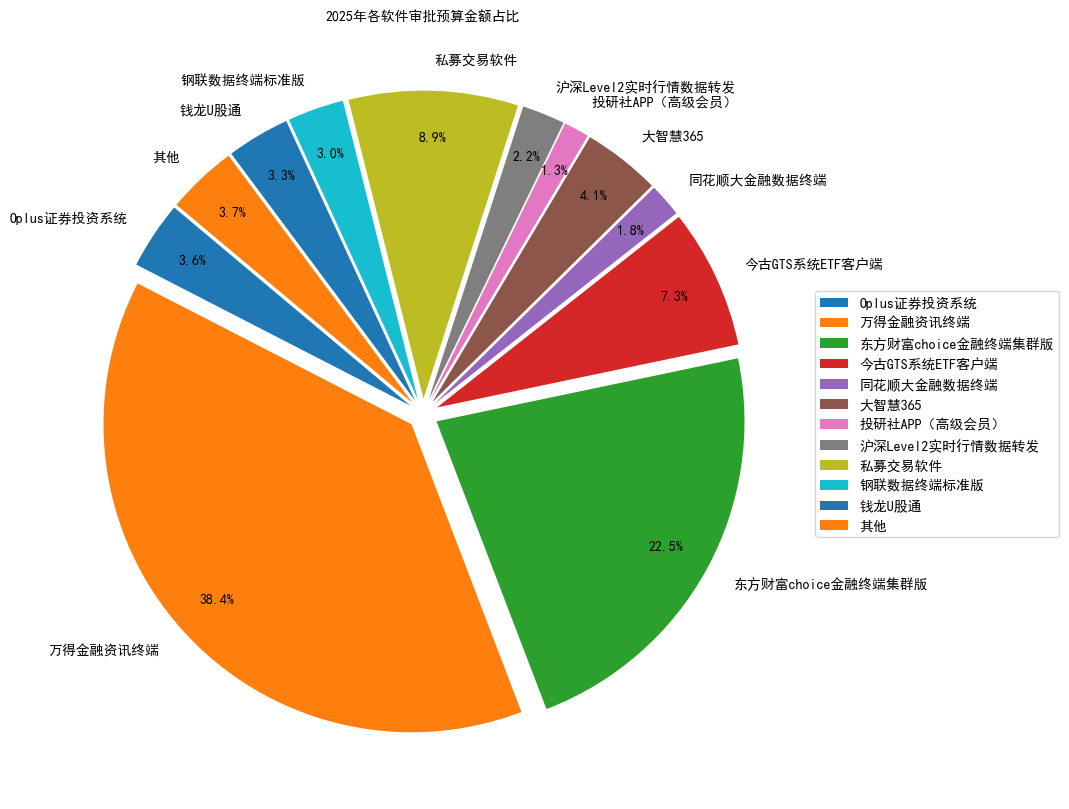

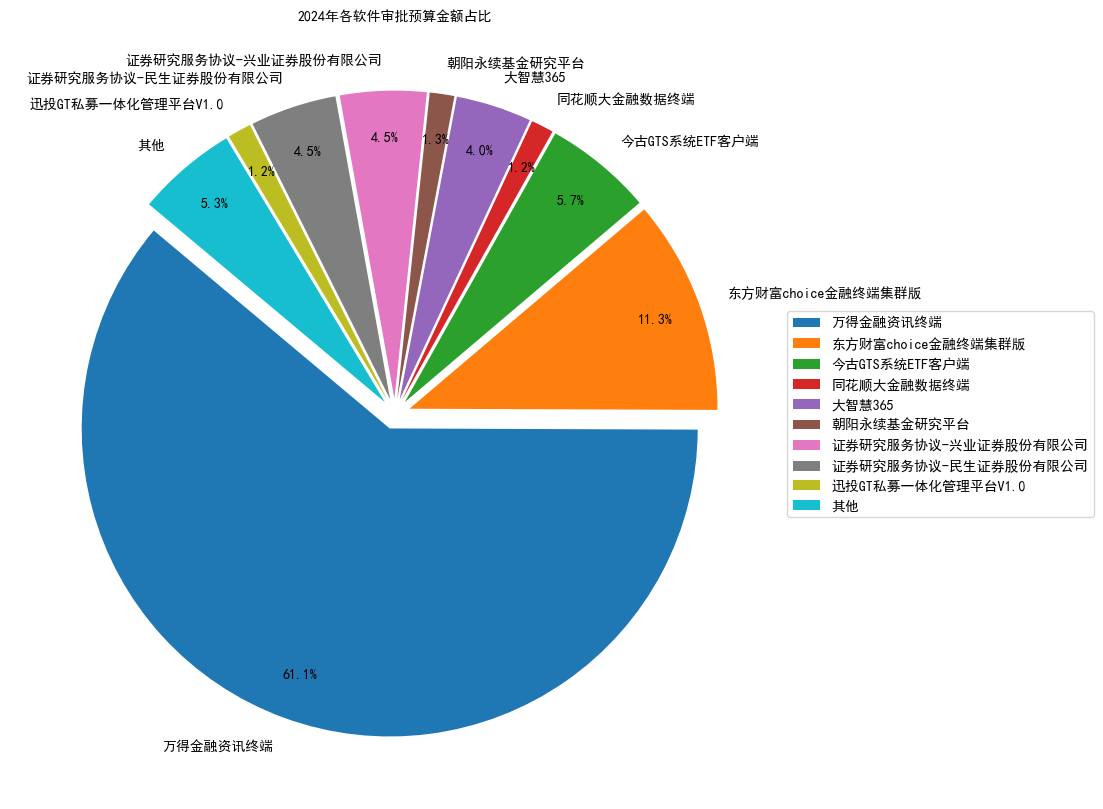

In [174]:
# 4-不同软件的采购占比-2025
font = FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf', size=10)

# 读取数据
data = pd.read_csv("./datasets/2022-2025软件、资讯类采购预算及执行情况_analysis.csv")

# 筛选出2025年的数据
data_2025 = data[(data['年份'] == 2025) & (data['审批金额不含税'].notnull())]

# 按照软件名称汇总审批金额不含税
software_amount = data_2025.groupby('软件名称')['审批金额不含税'].sum().reset_index()

# 计算总审批金额不含税
total_amount = software_amount['审批金额不含税'].sum()

# 计算各软件审批金额不含税占比
software_amount['占比'] = software_amount['审批金额不含税'] / total_amount

# 筛选出占比小于1%的软件并合并为“其他”
others_mask = software_amount['占比'] < 0.01
others_amount = software_amount[others_mask]['审批金额不含税'].sum()
others_percentage = software_amount[others_mask]['占比'].sum()
new_software_amount = software_amount[~others_mask]
others_df = pd.DataFrame({'软件名称': ['其他'], '审批金额不含税': [others_amount], '占比': [others_percentage]})
new_software_amount = pd.concat([new_software_amount, others_df], ignore_index=True)

# 绘制饼状图
explode = tuple([0.05] * len(new_software_amount))
plt.figure(figsize=(10, 10))
patches, texts, autotexts = plt.pie(new_software_amount['占比'], explode=explode,
                                    labels=new_software_amount['软件名称'],
                                    autopct='%1.1f%%', startangle=140, pctdistance=0.85)

# 设置饼图中文标签字体
for text in texts:
    text.set_fontproperties(font)
for autotext in autotexts:
    autotext.set_fontproperties(font)

# 添加图例
plt.legend(patches, new_software_amount['软件名称'], loc='center left', bbox_to_anchor=(1, 0.5), prop=font)

plt.title('2025年各软件审批预算金额占比', fontproperties=font)
plt.show()

#####################################################################################################################################################

# 4-不同软件的采购占比-2024
font = FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf', size=10)

# 读取数据
data = pd.read_csv("./datasets/2022-2025软件、资讯类采购预算及执行情况_analysis.csv")

# 筛选出2024年的数据
data_2024 = data[(data['年份'] == 2024) & (data['审批金额不含税'].notnull())]

# 按照软件名称汇总审批金额不含税
software_amount = data_2024.groupby('软件名称')['审批金额不含税'].sum().reset_index()

# 计算总审批金额不含税
total_amount = software_amount['审批金额不含税'].sum()

# 计算各软件审批金额不含税占比
software_amount['占比'] = software_amount['审批金额不含税'] / total_amount

# 筛选出占比小于1%的软件并合并为“其他”
others_mask = software_amount['占比'] < 0.01
others_amount = software_amount[others_mask]['审批金额不含税'].sum()
others_percentage = software_amount[others_mask]['占比'].sum()
new_software_amount = software_amount[~others_mask]
others_df = pd.DataFrame({'软件名称': ['其他'], '审批金额不含税': [others_amount], '占比': [others_percentage]})
new_software_amount = pd.concat([new_software_amount, others_df], ignore_index=True)

# 绘制饼状图
explode = tuple([0.05] * len(new_software_amount))
plt.figure(figsize=(10, 10))
patches, texts, autotexts = plt.pie(new_software_amount['占比'], explode=explode,
                                    labels=new_software_amount['软件名称'],
                                    autopct='%1.1f%%', startangle=140, pctdistance=0.85)

# 设置饼图中文标签字体
for text in texts:
    text.set_fontproperties(font)
for autotext in autotexts:
    autotext.set_fontproperties(font)

# 添加图例
plt.legend(patches, new_software_amount['软件名称'], loc='center left', bbox_to_anchor=(1, 0.5), prop=font)

plt.title('2024年各软件审批预算金额占比', fontproperties=font)
plt.show()


In [ ]:
# 分析结论：
1-
2-
3-

